# Calculating P-values

### Introduction

In the previous lesson, we saw how to calculate set up a hypothesis test, and from there calculate the p value of an apparent effect.  In this lesson, we'll try to use this technique to see if see if there is evidence of different kinds of health effects from individuals getting insurance.

### Loading our Data

Let's start by loading our data.

In [3]:
import pandas as pd
url = "oregon_health_insurance.csv"
df = pd.read_csv(url, index_col = 0)

In [4]:
df[:3]

,treatment,depression_pre,depression_post,bp_dias,bp_syst,er_visits,borrow_for_med
0,Selected,No,No,81.0,144.0,0.0,No
1,Not selected,No,No,82.0,134.0,2.0,Yes
2,Not selected,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.shape

(20745, 7)

### Cleaning the Data

Ok, now let's remove all rows that have any NA values.

In [191]:
import numpy as np
df_not_na = df[np.all(~df.isna(), axis = 1)]

In [194]:
df_not_na.shape
# (12021, 7)

(12021, 7)

Let's see the percentage of the rows that we lost.

In [196]:
df_not_na.shape[0]/df.shape[0]
# 0.5794649313087491

0.5794649313087491

Now, let's take a look at some of our data.

In [42]:
df_not_na[:3]

,treatment,depression_pre,depression_post,bp_dias,bp_syst,er_visits,borrow_for_med
0,Selected,No,No,81.0,144.0,0.0,No
1,Not selected,No,No,82.0,134.0,2.0,Yes
4,Not selected,Yes,No,110.0,168.0,1.0,No


Now we want to coerce our columns our values into numbers.  So let's change the values for `depression_pre` to 1 where the value is Yes, and 0 where the value is No.  Do the same for `depression_post`.  And finally for treatment, change to a 1 for selected and 0 for Not Selected.  

In [54]:
depression_pre = df_not_na['depression_pre'].map({'No': 0, 'Yes': 1})

In [200]:
depression_pre[:4]
# 0    0
# 1    0
# 4    1
# 5    0

0    0
1    0
4    1
5    0
Name: depression_pre, dtype: int64

In [55]:
depression_post = df_not_na['depression_post'].map({'No': 0, 'Yes': 1})

In [202]:
depression_post[:4]
# 0    0
# 1    0
# 4    0
# 5    0

0    0
1    0
4    0
5    0
Name: depression_post, dtype: int64

In [56]:
treatment = df_not_na['treatment'].map({'Selected': 1, 'Not selected': 0})

In [204]:
treatment[:4]

# 0    1
# 1    0
# 4    0
# 5    0

0    1
1    0
4    0
5    0
Name: treatment, dtype: int64

In [59]:
borrow_for_med = df_not_na['borrow_for_med'].map({'Yes': 1, 'No': 0})

In [206]:
borrow_for_med[:3]
# 0    0
# 1    1
# 4    0

0    0
1    1
4    0
Name: borrow_for_med, dtype: int64

In [208]:
df_not_na = df_not_na.assign(treatment = treatment, 
                 depression_pre = depression_pre,
                 depression_post = depression_post,
                 borrow_for_med = borrow_for_med)

In [209]:
df_not_na[:3]

,treatment,depression_pre,depression_post,bp_dias,bp_syst,er_visits,borrow_for_med
0,1,0,0,81.0,144.0,0.0,0
1,0,0,0,82.0,134.0,2.0,1
4,0,1,0,110.0,168.0,1.0,0


Now assign those who have been selected to one df.  And those who have not been selected to another df.

Let's add another column called `depression_improved` which is the `depression_pre` - `depression_post`.

In [210]:
df_not_na = df_not_na.assign(depression_improved = depression_pre - depression_post)

In [211]:
df_not_na[:3]
# 	treatment	depression_pre	depression_post	bp_dias	bp_syst	er_visits	borrow_for_med	depression_improved
# 0	1	0	0	81.0	144.0	0.0	0	0
# 1	0	0	0	82.0	134.0	2.0	1	0
# 4	0	1	0	110.0	168.0	1.0	0	1

,treatment,depression_pre,depression_post,bp_dias,bp_syst,er_visits,borrow_for_med,depression_improved
0,1,0,0,81.0,144.0,0.0,0,0
1,0,0,0,82.0,134.0,2.0,1,0
4,0,1,0,110.0,168.0,1.0,0,1


So now, the idea is to see if there is a difference between the treatment and the control.  Let's separate the groups.

In [76]:
selected_df = df_not_na[df_not_na['treatment'] == 1]
not_selected_df = df_not_na[df_not_na['treatment'] == 0]

### Is there a change in Blood Pressure?

Now let's see if there's a difference in the means.

In [219]:
bp_mean_selected = selected_df['bp_dias'].mean()
bp_mean_selected
# 75.615

75.61589931495938

In [220]:
bp_mean_not_selected = not_selected_df['bp_dias'].mean()
bp_mean_not_selected
# 75.8957

75.895717270195

So our null hypothesis is that the mean blood pressure is 75.89, and our alternative is that it's less than 75.89.  Let's set a significance level of $\alpha = .01$.

Now the question is, what is the probability that this difference is due to chance.  To do this, we first calculated the standard error, or the standard deviation of the means.

In [216]:
se_bp = df_not_na['bp_dias'].std()/np.sqrt(selected_df.shape[0])

In [217]:
se_bp

0.1510418338907978

Now one way to get a sense of how rare this would be is with the z-score.  

In [222]:
z = (bp_mean_selected - bp_mean_not_selected)/se_bp
z
# -1.8525

-1.8525857904898124

So we can see that this is less than two standard deviations away.  We can already see that this may not meet our threshold for a p-value. 

To be sure, we let's plot our distribution of the means and then calculate the cdf.

In [223]:
import scipy.stats as stats
import numpy as np
norm_dist_bp = stats.norm(bp_mean_not_selected, se_bp)

In [224]:
x_vals = np.linspace(norm_dist_bp.ppf(0.00001), norm_dist_bp.ppf(0.99999), 100)
pdf_nums_norm_bp = norm_dist_bp.pdf(x_vals)

[Text(0.5, 1.0, 'distribution means bp')]

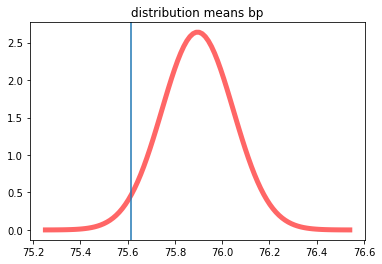

In [226]:
from scipy.stats import norm
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_vals, pdf_nums_norm_bp,
'r-', lw=5, alpha=0.6, label='norm pdf')
ax.axvline(x=bp_mean_selected)
ax.set(title = 'distribution means bp')

In [228]:
norm_dist_bp.cdf(bp_mean_selected)

0.03197087533560207

So three percent of the time, even if there was no effect, we would still see the above difference in means.  We do not reject the null hypothesis.

### Change in Borrow for Medicine?

Now do the same for the `borrow_for_med` variable.  What is the probability that the apparent effect is due to chance, assuming the null hypothesis is true.

1. Start by stating the null hypothesis.

2. Then calculate the z-score

In [97]:
selected_borrow_mean = selected_df['borrow_for_med'].mean()

In [98]:
not_selected_borrow_mean = not_selected_df['borrow_for_med'].mean()

In [94]:
df_not_na['borrow_for_med'].std()

0.4182704057570907

In [237]:
se = df_not_na['borrow_for_med'].std()/np.sqrt(df_not_na.shape[0])

In [238]:
se

0.0038149323328362894

In [232]:
z_borrow = None
# -10.202037

In [239]:
import scipy.stats as stats
import numpy as np
norm_dist_borrow = stats.norm(not_selected_borrow_mean, 0.003814)
norm_dist_borrow

In [248]:
x_vals = np.linspace(norm_dist_borrow.ppf(0.0000001), norm_dist_borrow.ppf(0.9999999), 100)
pdf_nums_norm_borrow = norm_dist_borrow.pdf(x_vals)

[Text(0.5, 1.0, 'normal distribution')]

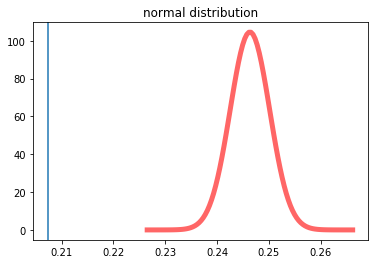

In [249]:
from scipy.stats import norm
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_vals, pdf_nums_norm_borrow,
'r-', lw=5, alpha=0.6, label='norm pdf')
ax.axvline(x=selected_borrow_mean)
ax.set(title = 'normal distribution')

So this likely did not occur do to chance.

In [250]:
norm_dist_borrow.cdf(selected_borrow_mean)
# 9.461625509785145e-25

9.461625509785145e-25

### Change in ER Visits

This time, for ER visits, note that number could have gone up or down.  So let's set up our null and alternative hypotheses like so.

In [277]:
not_selected_er_mean = not_selected_df['er_visits'].mean()
not_selected_er_mean
# 1.03899

1.0389972144846797

* $H_0: er = 1.038$
* $H_A: er \neq 1.038$

In [276]:
selected_er_mean = selected_df['er_visits'].mean()
selected_er_mean

1.0900111518241198

Now for ER visits as well, calculate the z score of the apparent effect.

In [275]:
z_er_visits = None
z_er_visits
# 2.058165006183973

Then we plot the scores.

In [267]:
import scipy.stats as stats
import numpy as np
norm_dist_er = stats.norm(not_selected_er_mean, se_er_visits)

In [268]:
x_vals = np.linspace(norm_dist_er.ppf(0.00001), norm_dist_er.ppf(0.99999), 100)
pdf_nums_norm = norm_dist_er.pdf(x_vals)

[Text(0.5, 1.0, 'normal distribution')]

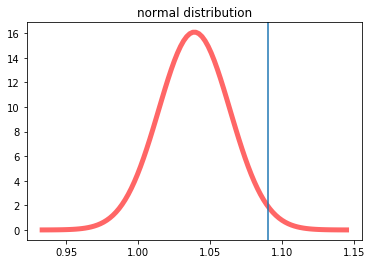

In [269]:
from scipy.stats import norm
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_vals, pdf_nums_norm,
'r-', lw=5, alpha=0.6, label='norm pdf')
ax.axvline(x=selected_er_mean)
ax.set(title = 'normal distribution')

Now this time, because in our hypothesis we did not choose a side, we ask not the probability that we received a deviation this large in the positive direction, but that we would see a deviation this large in either direction.  So our formula is the following.

In [274]:
2*(1 - norm_dist_er.cdf(selected_er_mean))
# 0.0395

0.03957429654555744

So there is a four percent chance that we would see this difference even if there were no effect.  We fail to reject the null hypothesis.

### Summary 

In this lesson, we saw how to calculate p-values.  Our general approach is to calculate the difference in the means, and then to see the likelihood that the difference in the means was due to chance.  We do that by looking at the standard deviation of the means (the standard error), and seeing the likelihood that the difference in the means is due to the standard deviation in the means.  